In [1]:
import numpy as np 
from scipy.io import loadmat
import os
from os.path import join as opj
from h5py import File
import pandas as pd

# load CLIP from huggingface, load the first N images and extract the features
from transformers import CLIPProcessor, CLIPModel
import torch
import tqdm
from PIL import Image

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path ="/home/matteo/storage/THINGS_Monkey"
monkey = "F"
os.listdir(base_path)

['THINGS_normMUA_F.mat',
 'THINGS_normMUA_N.mat',
 'THINGS_MUA_trials_N.mat',
 'THINGS_MUA_trials_F.mat',
 'THINGS_normMUA.mat',
 'things_imgs_F.mat']

In [5]:
things_imgs = File(opj(base_path,f'things_imgs_{monkey}.mat'))
train_imgs = things_imgs['train_imgs']   # group object --> <HDF5 group "/train_imgs" (3 members)>
test_imgs = things_imgs['test_imgs']


In [3]:
def resolve_reference(hdf5_file, ref):
    """
    Resolve an HDF5 dataset reference and convert it into a string.
    """
    data = hdf5_file[ref][:]
    return ''.join(chr(i) for i in data.flatten() if i > 0)

In [6]:
train_classes = []
train_local_paths = []
train_things_paths = []

test_classes = []
test_local_paths = []
test_things_paths = []

with File(opj(base_path, f"things_imgs_{monkey}.mat")) as f:
    train_imgs = f['train_imgs']
    
    train_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['class']]
    train_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['local_path']]
    train_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['things_path']]

    test_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['class']]
    test_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['local_path']]
    test_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['things_path']]

In [7]:
trials = File(opj(base_path, f"THINGS_MUA_trials_{monkey}.mat"))
df =pd.DataFrame(trials["ALLMAT"][:].T, columns=["#trial_idx", "#train_idx", "#test_idx", "#rep", "#count", "#correct"])

df

,#trial_idx,#train_idx,#test_idx,#rep,#count,#correct
0,1.0,16504.0,0.0,1.0,1.0,1.0
1,2.0,16470.0,0.0,1.0,2.0,1.0
2,3.0,15094.0,0.0,1.0,3.0,1.0
3,4.0,2514.0,0.0,1.0,4.0,1.0
4,5.0,4860.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
25243,25244.0,0.0,40.0,30.0,1.0,4.0
25244,25245.0,13906.0,0.0,1.0,2.0,4.0
25245,25246.0,470.0,0.0,1.0,3.0,4.0
25246,25247.0,15559.0,0.0,1.0,4.0,4.0


In [8]:
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/trials_allmua.npy', data)
data = np.load('/srv/nfs-data/sisko/matteoc/monkeys/trials_allmua.npy')

print(data.shape)

(300, 25248, 1024)


## Extract Images

In [9]:
thing_base_path = "/home/matteo/storage/THINGS_img/"
N = 15000      # TODO: prenderli tutti (dati training)

train_indices = df[df["#train_idx"]!=0]["#train_idx"].values.astype(int) - 1
test_indices = df[df["#test_idx"]!=0]["#test_idx"].values.astype(int) - 1

sorted_train_img_path = [train_things_paths[i] for i in train_indices]
sorted_test_img_path = [test_things_paths[i] for i in test_indices]

In [17]:
# device = "cuda:3" if torch.cuda.is_available() else "cpu"

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def extract_features(model, images):
#     images = [Image.open(img).convert("RGB") for img in images]
#     inputs = processor(images= images, return_tensors="pt", padding=True)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = model.get_image_features(**inputs)
#     return outputs

# batch = 256
# train_features = []
# test_features = []

# for i in tqdm.trange(0, N, batch):
#     features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_train_img_path[i:i+batch]])
#     train_features.append(features.cpu().numpy())

# for i in tqdm.trange(0, len(sorted_test_img_path), batch):
#     features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_test_img_path[i:i+batch]])
#     test_features.append(features.cpu().numpy())

# train_features = np.concatenate(train_features, axis=0)[:N]
# test_features = np.concatenate(test_features, axis=0)


In [10]:
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/train_features.npy', train_features)
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/test_features.npy', test_features)

train_features = np.load('/srv/nfs-data/sisko/matteoc/monkeys/train_features.npy')
test_features = np.load('/srv/nfs-data/sisko/matteoc/monkeys/test_features.npy')

In [11]:
train_features.shape, test_features.shape

((15000, 512), (3000, 512))

In [12]:
neural_train_trial_idx = df[df["#train_idx"]!=0]["#trial_idx"].values.astype(int) - 1
neural_test_trial_idx = df[df["#test_idx"]!=0]["#trial_idx"].values.astype(int) - 1

train_neural = data[:,neural_train_trial_idx[:N]]      # prendo tutte le osservazioni --> no data[:,neural_train_trial_idx[:N]]     
test_neural = data[:,neural_test_trial_idx]
print(train_neural.shape, test_neural.shape)     # SHAPE: num_timepoints, observation, electrodes

(300, 15000, 1024) (300, 3000, 1024)


## Avg activity over repetitions

In [13]:
test_neural_avg = []
test_features_avg = []
selected_test_imgs = []
for idx in tqdm.tqdm(np.unique(test_indices)):
    test_neural_avg.append(test_neural[:,test_indices==idx].mean(1))
    #same for the test features
    test_features_avg.append(test_features[test_indices==idx].mean(0))
    selected_test_imgs.append(np.array(sorted_test_img_path)[test_indices==idx][0])

test_neural_avg = np.array(test_neural_avg).transpose(1,0,-1)
test_features_avg = np.array(test_features_avg)
selected_test_imgs = np.array(selected_test_imgs)

print(test_neural_avg.shape, test_features_avg.shape, selected_test_imgs.shape)

100%|██████████| 100/100 [00:01<00:00, 77.55it/s]


(300, 100, 1024) (100, 512) (100,)


In [14]:
test_neural_avg.shape, test_features_avg.shape, train_features.shape, train_neural.shape     # TODO: primi 100 di prestimolo

((300, 100, 1024), (100, 512), (15000, 512), (300, 15000, 1024))

## Time Neural Network

In [15]:
train_neural = train_neural[100:]  # (200, 15000, 1024)
test_neural_avg = test_neural_avg[100:]  # (200, 100, 1024)

In [16]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
    

class TemporalNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, hidden_dim=768, output_dim=512, num_layers=1, tau=0.05, lr=1e-4):
        super().__init__()

        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=False)
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_fn = nn.MSELoss()
        self.tau = tau
        self.lr = lr
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch, time, hidden)
        final_hidden = rnn_out[:, -1, :]  
        # final_hidden = torch.mean(rnn_out, dim=1)
        return self.mlp(final_hidden)
    
    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        loss_mse = self.loss_fn(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        loss_mse = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

class SimpleTCN(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-3, tau=0.05):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 128, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, 1024, 200)
        x = self.conv(x).squeeze(-1)  # (batch, 128)
        return self.mlp(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    




In [17]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x
    

class TransformerNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, d_model=256, nhead=8, num_layers=4, output_dim=512, tau=0.05, lr=1e-3):
        super().__init__()
        
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)  # mean pooling across time
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_fn = nn.MSELoss()
        self.tau = tau
        self.lr = lr
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def forward(self, x):  # x: (batch, time, channels)
        x = self.input_proj(x)         # → (batch, time, d_model)
        x = self.pos_encoding(x)       # + positional encodings
        x = self.transformer(x).reshape(x.shape[0], self.d_model, -1)       # → (batch, d_model, time)
        x = self.pooling(x).squeeze(-1)              # mean pooling across time
        return self.mlp(x)             # → (batch, output_dim)
    
    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss_mse = self.loss_fn(preds, y)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss_mse = self.loss_fn(preds, y)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)



In [68]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

batch_size = 256
device = 'cuda:2'
cuda_d = 2
seed = 42

X_train = train_neural.transpose(1, 0, 2)  
Y_train = train_features  
X_test = test_neural_avg.transpose(1, 0, 2)  # shape: (15000, 200, 1024)
Y_test = test_features_avg 

scaler_X = StandardScaler()
X_reshaped = X_train.reshape(-1, X_train.shape[-1])  
# X_reshaped = X_train.reshape(X_train.shape[0], -1)
X_scaled = scaler_X.fit_transform(X_reshaped)
X_train_tensor = torch.tensor(X_scaled.reshape(15000, 200, 1024), dtype=torch.float32, device=device)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1]) 
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_tensor = torch.tensor(X_test_scaled.reshape(100, 200, 1024), dtype=torch.float32, device=device)


In [ ]:
dataset = TensorDataset(X_train_tensor, torch.tensor(Y_train, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import geomloss 


class LinearFlatTime(pl.LightningModule):
    def __init__(self, input_dim=1024*200, output_dim=512, lr=1e-3, tau=0.05):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):     # shape: (batch, 200, 1024)
        x = x.reshape(x.shape[0], -1)  
        output = self.linear(x)
        return output

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss_cl = self.contrastive_loss_nt(cos_matrix, self.tau)
        mse_loss = self.loss_mse(self(x), y)
        self.log("train_loss", loss_cl, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss_cl

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_cl(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss_cl = self.contrastive_loss_nt(cos_matrix, self.tau)
        mse_loss = self.loss_mse(self(x), y)
        self.log("val_loss", loss_cl, on_epoch=True, prog_bar=True)
        return loss_cl

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    

class MlpAvgTime(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-4, tau=0.05):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(768, output_dim)
        )
        self.linear = nn.Sequential(     # TODO: provare OT + CL in questo caso qua
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):     # shape: (batch, 200, 1024)
        x = x.mean(dim=1)  
        output = self.linear(x)
        return output

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss_cl = self.contrastive_loss_nt(cos_matrix, self.tau)
        mse_loss = self.loss_mse(self(x), y)
        self.log("train_loss", loss_cl, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss_cl

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_cl(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss_cl = self.contrastive_loss_nt(cos_matrix, self.tau)
        mse_loss = self.loss_mse(self(x), y)
        self.log("val_loss", loss_cl, on_epoch=True, prog_bar=True)
        return loss_cl

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)


In [67]:
class SoftMapping(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-4, tau=0.05):
        super().__init__()

        self.attn_mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        self.attn_linear = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Dropout(0.5)
        )
        self.lin = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):     # shape: (batch, 200, 1024)
        # attn_weights = torch.softmax(self.attn_linear(x), dim=1)
        attn_weights = torch.sigmoid(self.attn_linear(x))
        attn_out = torch.mean(attn_weights * x, dim=1)
        output = self.lin(attn_out)
        return output

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_cl(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    

In [69]:
pl.seed_everything(seed, workers=True)
model = SoftMapping()
logger = CSVLogger("/home/matteoc/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=50, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
trainer.fit(model, train_loader, val_loader)

Seed set to 42
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteoc/miniconda3/envs/speech-meg/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | attn_mlp     | Sequential | 262 K 
1 | attn_linear  | Sequential | 1.0 K 
2 | lin          | Sequential | 524 K 
3 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.154     Total estima

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 47/47 [00:00<00:00, 136.85it/s, v_num=74, train_loss_step=4.960, tau=0.0501, val_loss=5.100, train_loss_epoch=5.380]

Metric val_loss improved. New best score: 5.101


Epoch 1: 100%|██████████| 47/47 [00:00<00:00, 151.59it/s, v_num=74, train_loss_step=4.480, tau=0.0498, val_loss=4.710, train_loss_epoch=4.840]

Metric val_loss improved by 0.387 >= min_delta = 0.09. New best score: 4.714


Epoch 2: 100%|██████████| 47/47 [00:00<00:00, 164.15it/s, v_num=74, train_loss_step=4.280, tau=0.0494, val_loss=4.420, train_loss_epoch=4.430]

Metric val_loss improved by 0.296 >= min_delta = 0.09. New best score: 4.418


Epoch 3: 100%|██████████| 47/47 [00:00<00:00, 165.16it/s, v_num=74, train_loss_step=3.960, tau=0.0491, val_loss=4.220, train_loss_epoch=4.130]

Metric val_loss improved by 0.196 >= min_delta = 0.09. New best score: 4.222


Epoch 4: 100%|██████████| 47/47 [00:00<00:00, 164.62it/s, v_num=74, train_loss_step=3.670, tau=0.0487, val_loss=4.060, train_loss_epoch=3.900]

Metric val_loss improved by 0.158 >= min_delta = 0.09. New best score: 4.064


Epoch 5: 100%|██████████| 47/47 [00:00<00:00, 165.10it/s, v_num=74, train_loss_step=3.550, tau=0.0484, val_loss=3.940, train_loss_epoch=3.700]

Metric val_loss improved by 0.119 >= min_delta = 0.09. New best score: 3.945


Epoch 6: 100%|██████████| 47/47 [00:00<00:00, 164.34it/s, v_num=74, train_loss_step=3.300, tau=0.048, val_loss=3.840, train_loss_epoch=3.540] 

Metric val_loss improved by 0.107 >= min_delta = 0.09. New best score: 3.838


Epoch 8: 100%|██████████| 47/47 [00:00<00:00, 157.11it/s, v_num=74, train_loss_step=3.170, tau=0.0474, val_loss=3.680, train_loss_epoch=3.270]

Metric val_loss improved by 0.158 >= min_delta = 0.09. New best score: 3.680


Epoch 10: 100%|██████████| 47/47 [00:00<00:00, 166.50it/s, v_num=74, train_loss_step=2.940, tau=0.0468, val_loss=3.550, train_loss_epoch=3.040]

Metric val_loss improved by 0.127 >= min_delta = 0.09. New best score: 3.552


Epoch 12: 100%|██████████| 47/47 [00:00<00:00, 172.22it/s, v_num=74, train_loss_step=2.740, tau=0.0462, val_loss=3.460, train_loss_epoch=2.850]

Metric val_loss improved by 0.091 >= min_delta = 0.09. New best score: 3.461


Epoch 15: 100%|██████████| 47/47 [00:00<00:00, 166.37it/s, v_num=74, train_loss_step=2.560, tau=0.0453, val_loss=3.340, train_loss_epoch=2.610]

Metric val_loss improved by 0.117 >= min_delta = 0.09. New best score: 3.345


Epoch 19: 100%|██████████| 47/47 [00:00<00:00, 161.69it/s, v_num=74, train_loss_step=2.240, tau=0.0443, val_loss=3.230, train_loss_epoch=2.350]

Metric val_loss improved by 0.111 >= min_delta = 0.09. New best score: 3.234


Epoch 24: 100%|██████████| 47/47 [00:00<00:00, 181.84it/s, v_num=74, train_loss_step=1.940, tau=0.043, val_loss=3.140, train_loss_epoch=2.070] 

Metric val_loss improved by 0.098 >= min_delta = 0.09. New best score: 3.136


Epoch 31: 100%|██████████| 47/47 [00:00<00:00, 188.02it/s, v_num=74, train_loss_step=1.690, tau=0.0414, val_loss=3.040, train_loss_epoch=1.760]

Metric val_loss improved by 0.097 >= min_delta = 0.09. New best score: 3.039


Epoch 41: 100%|██████████| 47/47 [00:00<00:00, 166.38it/s, v_num=74, train_loss_step=1.330, tau=0.0393, val_loss=2.960, train_loss_epoch=1.420]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.039. Signaling Trainer to stop.


Epoch 41: 100%|██████████| 47/47 [00:00<00:00, 143.89it/s, v_num=74, train_loss_step=1.330, tau=0.0393, val_loss=2.960, train_loss_epoch=1.420]


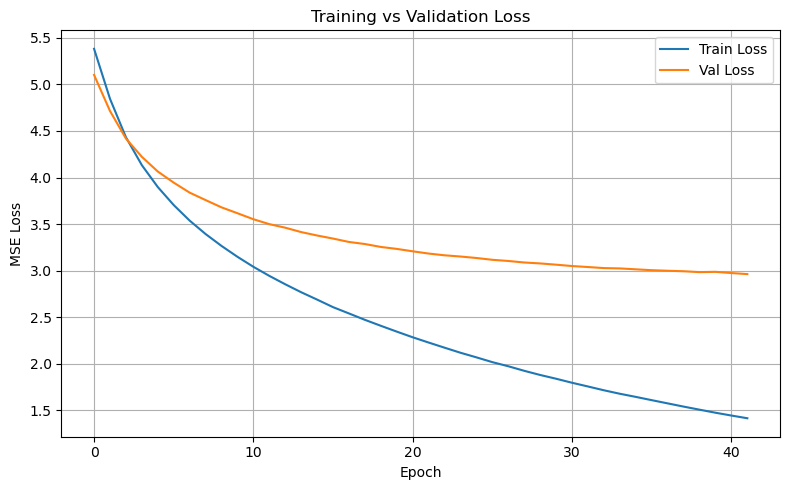

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = logger.log_dir + "/metrics.csv"
df = pd.read_csv(log_path)

val_loss_df = df[~df["val_loss"].isna()]
train_loss_df = df[~df["train_loss_epoch"].isna()]
plt.figure(figsize=(8, 5))
plt.plot(np.array(train_loss_df["epoch"]), np.array(train_loss_df["train_loss_epoch"]), label="Train Loss")
plt.plot(np.array(val_loss_df["epoch"]), np.array(val_loss_df["val_loss"]), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# SoftMapping(
#   (attn_mlp): Sequential(
#     (0): Linear(in_features=1024, out_features=256, bias=True)
#     (1): GELU(approximate='none')
#     (2): Dropout(p=0.5, inplace=False)
#     (3): Linear(in_features=256, out_features=1, bias=True)
#   )
#   (attn_linear): Sequential(
#     (0): Linear(in_features=1024, out_features=1, bias=True)
#     (1): Dropout(p=0.5, inplace=False)
#   )
#   (lin): Sequential(
#     (0): Linear(in_features=1024, out_features=512, bias=True)
#   )
#   (loss_mse): MSELoss()
# )



# SoftMapping - MSE
# Top-1 accuracy: 31/100 (31.00%)
# Top-3 accuracy: 66/100 (66.00%)

# SimpleTCN
# Top-1 accuracy: 49/100 (49.00%)
# Top-3 accuracy: 85/100 (85.00%)

# TempralNeuraToFeature (GRU)
# Top-1 accuracy: 27/100 (27.00%)
# Top-3 accuracy: 61/100 (61.00%)

# TransformerNeuralToFeature
# Top-1 accuracy: 34/100 (34.00%)
# Top-3 accuracy: 72/100 (72.00%)

In [71]:
# tgt_dir = "/srv/nfs-data/sisko/matteoc/monkeys/"
# torch.save(model.state_dict(), f"{tgt_dir}/softmapping_state_dict.pt")
# torch.save(model.attn_linear.state_dict(), f"{tgt_dir}/attn_linear.pt")
# torch.save(model.mlp.state_dict(), f"{tgt_dir}/mlp.pt")
# print(model.tau)
# print(model.lr)

# clone_model = SoftMapping(input_dim=1024, output_dim=512, lr=1e-3, tau=0.05).to(device)
# state_dict = torch.load(f"{tgt_dir}/softmapping_state_dict.pt")
# attn_linear_state_dict = torch.load(f"{tgt_dir}/attn_linear.pt")
# mlp_state_dict = torch.load(f"{tgt_dir}/mlp.pt")
# clone_model.load_state_dict(state_dict)
# clone_model.attn_linear.load_state_dict(attn_linear_state_dict)
# clone_model.mlp.load_state_dict(mlp_state_dict)

# with torch.no_grad():
#     for x, y in test_loader:
#         model_original = model.to(device)
#         y_hat_original = model_original(x)
#         y_hat_clone = clone_model(x)
#         assert torch.allclose(y_hat_original, y_hat_clone, atol=1e-6), "Mismatch negli output!"
#         break

In [71]:
x,y = next(iter(test_loader))

y_pred=[]
y_true=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader):
        clone_model_ent = model.to(device)
        y_hat = clone_model_ent(x)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)

100%|██████████| 1/1 [00:00<00:00, 618.26it/s]


In [72]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 64/100 (64.00%)
Top-5 accuracy: 88/100 (88.00%)


## Top Channels Trials

In [86]:
top_global_channels = torch.load('/srv/nfs-data/sisko/storage/THINGS_img/top_global_channels_F.pt')
print(top_global_channels.shape)

(667,)


In [231]:
top_global_channels_mv = np.array([t.item() for t in top_global_channels])

X_train_tensor = X_train_tensor[:, :, top_global_channels_mv]
X_test_tensor = X_test_tensor[:, :, top_global_channels_mv]

In [232]:
dataset = TensorDataset(X_train_tensor, torch.tensor(train_features, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_features_avg, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [243]:
pl.seed_everything(seed, workers=True)
# model_top_channels = SoftMapping(input_dim=667)
# model_top_channels = MlpAvgTime(input_dim=667)
model_top_channels = LinearFlatTime(input_dim=667*200)
logger = CSVLogger("/home/matteoc/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.10, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=50, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  # Usa GPU se disponibile, 35 epoche per il SoftMapping
trainer.fit(model_top_channels, train_loader, val_loader)

Seed set to 42
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteoc/miniconda3/envs/speech-meg/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | linear       | Sequential | 68.3 M
1 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
68.3 M    Trainable params
0         Non-trainable params
68.3 M    Total params
273.205   Total estimated model params size (MB)


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 47/47 [00:00<00:00, 85.06it/s, v_num=67, train_loss_step=4.900, tau=0.0512, val_loss=5.050, train_loss_epoch=5.360]

Metric val_loss improved. New best score: 5.047


Epoch 1: 100%|██████████| 47/47 [00:00<00:00, 63.50it/s, v_num=67, train_loss_step=3.650, tau=0.0489, val_loss=4.270, train_loss_epoch=4.260]

Metric val_loss improved by 0.777 >= min_delta = 0.1. New best score: 4.270


Epoch 2: 100%|██████████| 47/47 [00:00<00:00, 83.85it/s, v_num=67, train_loss_step=1.580, tau=0.0451, val_loss=3.480, train_loss_epoch=2.110]

Metric val_loss improved by 0.794 >= min_delta = 0.1. New best score: 3.476


Epoch 12: 100%|██████████| 47/47 [00:00<00:00, 85.17it/s, v_num=67, train_loss_step=0.00826, tau=0.0404, val_loss=3.850, train_loss_epoch=0.00775]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.476. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 47/47 [00:05<00:00,  8.80it/s, v_num=67, train_loss_step=0.00826, tau=0.0404, val_loss=3.850, train_loss_epoch=0.00775]


In [244]:
x,y = next(iter(test_loader))

y_pred=[]
y_true=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader):
        model_top = model_top_channels.to(device)
        y_hat = model_top(x)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)

100%|██████████| 1/1 [00:00<00:00, 33.00it/s]


In [245]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 47/100 (47.00%)
Top-5 accuracy: 77/100 (77.00%)


## Channels PCA

In [60]:
from sklearn.decomposition import PCA

n_components = 32
pca = PCA(n_components=n_components)
X_train_pca_flat = pca.fit_transform(X_scaled) 
X_train_pca = X_train_pca_flat.reshape(X_train.shape[0], X_train.shape[1], n_components)

X_test_pca_flat = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_flat.reshape(X_test.shape[0], X_test.shape[1], n_components)

X_train_tensor_pca = torch.tensor(X_train_pca.reshape(15000, 200, n_components), dtype=torch.float32, device=device)
X_test_tensor_pca = torch.tensor(X_test_pca.reshape(100, 200, n_components), dtype=torch.float32, device=device)

In [61]:
dataset_pca = TensorDataset(X_train_tensor_pca, torch.tensor(Y_train, dtype=torch.float32, device=device))
test_dataset_pca = TensorDataset(X_test_tensor_pca, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset_pca))  
train_size = len(dataset_pca) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset_pca, val_dataset_pca = random_split(dataset_pca, [train_size, val_size], generator=generator1)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=batch_size, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

In [62]:
pl.seed_everything(seed, workers=True)
model_pca = SoftMapping(input_dim=n_components, output_dim=512, lr=1e-4, tau=0.05)
logger = CSVLogger("/home/matteoc/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=100, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
trainer.fit(model_pca, train_loader_pca, val_loader_pca)

Seed set to 42
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteoc/miniconda3/envs/speech-meg/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | attn_mlp     | Sequential | 8.7 K 
1 | attn_linear  | Sequential | 33    
2 | lin          | Sequential | 16.9 K
3 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
25.6 K    Trainable params
0         Non-trainable params
25.6 K    Total params
0.103     Total estima

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 47/47 [00:00<00:00, 190.42it/s, v_num=73, train_loss_step=5.530, tau=0.0502, val_loss=5.640, train_loss_epoch=5.690]

Metric val_loss improved. New best score: 5.642


Epoch 3: 100%|██████████| 47/47 [00:00<00:00, 163.05it/s, v_num=73, train_loss_step=5.420, tau=0.0508, val_loss=5.550, train_loss_epoch=5.580]

Metric val_loss improved by 0.091 >= min_delta = 0.09. New best score: 5.551


Epoch 7: 100%|██████████| 47/47 [00:00<00:00, 163.86it/s, v_num=73, train_loss_step=5.320, tau=0.0513, val_loss=5.450, train_loss_epoch=5.460]

Metric val_loss improved by 0.102 >= min_delta = 0.09. New best score: 5.448


Epoch 11: 100%|██████████| 47/47 [00:00<00:00, 163.23it/s, v_num=73, train_loss_step=5.190, tau=0.0513, val_loss=5.350, train_loss_epoch=5.360]

Metric val_loss improved by 0.094 >= min_delta = 0.09. New best score: 5.355


Epoch 16: 100%|██████████| 47/47 [00:00<00:00, 150.66it/s, v_num=73, train_loss_step=5.150, tau=0.0506, val_loss=5.240, train_loss_epoch=5.230]

Metric val_loss improved by 0.111 >= min_delta = 0.09. New best score: 5.244


Epoch 21: 100%|██████████| 47/47 [00:00<00:00, 149.21it/s, v_num=73, train_loss_step=4.960, tau=0.0492, val_loss=5.140, train_loss_epoch=5.120]

Metric val_loss improved by 0.106 >= min_delta = 0.09. New best score: 5.138


Epoch 26: 100%|██████████| 47/47 [00:00<00:00, 149.95it/s, v_num=73, train_loss_step=4.790, tau=0.0476, val_loss=5.040, train_loss_epoch=5.000]

Metric val_loss improved by 0.100 >= min_delta = 0.09. New best score: 5.038


Epoch 31: 100%|██████████| 47/47 [00:00<00:00, 149.84it/s, v_num=73, train_loss_step=4.770, tau=0.046, val_loss=4.940, train_loss_epoch=4.890] 

Metric val_loss improved by 0.093 >= min_delta = 0.09. New best score: 4.945


Epoch 37: 100%|██████████| 47/47 [00:00<00:00, 163.25it/s, v_num=73, train_loss_step=4.620, tau=0.0442, val_loss=4.840, train_loss_epoch=4.770]

Metric val_loss improved by 0.103 >= min_delta = 0.09. New best score: 4.842


Epoch 43: 100%|██████████| 47/47 [00:00<00:00, 162.74it/s, v_num=73, train_loss_step=4.510, tau=0.0426, val_loss=4.750, train_loss_epoch=4.650]

Metric val_loss improved by 0.093 >= min_delta = 0.09. New best score: 4.749


Epoch 50: 100%|██████████| 47/47 [00:00<00:00, 161.68it/s, v_num=73, train_loss_step=4.490, tau=0.0409, val_loss=4.650, train_loss_epoch=4.530]

Metric val_loss improved by 0.096 >= min_delta = 0.09. New best score: 4.653


Epoch 58: 100%|██████████| 47/47 [00:00<00:00, 184.05it/s, v_num=73, train_loss_step=4.290, tau=0.0391, val_loss=4.560, train_loss_epoch=4.400]

Metric val_loss improved by 0.094 >= min_delta = 0.09. New best score: 4.559


Epoch 68: 100%|██████████| 47/47 [00:00<00:00, 176.48it/s, v_num=73, train_loss_step=4.170, tau=0.0371, val_loss=4.460, train_loss_epoch=4.270]

Metric val_loss improved by 0.095 >= min_delta = 0.09. New best score: 4.464


Epoch 78: 100%|██████████| 47/47 [00:00<00:00, 154.66it/s, v_num=73, train_loss_step=4.010, tau=0.0352, val_loss=4.390, train_loss_epoch=4.160]

Monitored metric val_loss did not improve in the last 10 records. Best score: 4.464. Signaling Trainer to stop.


Epoch 78: 100%|██████████| 47/47 [00:00<00:00, 149.80it/s, v_num=73, train_loss_step=4.010, tau=0.0352, val_loss=4.390, train_loss_epoch=4.160]


## Ridge Regression

In [92]:
X_train_ridge = X_scaled.reshape(15000, 200, 1024)
X_test_ridge = X_test_scaled.reshape(100, 200, 1024)

In [87]:
top_global_channels_mv = np.array([t.item() for t in top_global_channels])

X_train_ridge = X_train_ridge[:, :, top_global_channels_mv]
X_test_ridge = X_test_ridge[:, :, top_global_channels_mv]

In [100]:
X_train_ridge.shape, X_test_ridge.shape, X_train_ridge.mean(), X_train_ridge.std(), Y_train.mean(), Y_train.std()

((15000, 200, 1024),
 (100, 200, 1024),
 2.8071032442955614e-15,
 0.9999999999999949,
 -0.012036878,
 0.47685653)

In [98]:
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend

vm = RidgeCV(alphas=[0.1,1,10,30,50,100,300])  

device_id = 1
backend = set_backend("torch_cuda")
X_train_F = backend.asarray(torch.tensor(X_train_ridge).float().mean(dim=1).to(f'cuda:{device_id}'))
Y_train_F = backend.asarray(torch.tensor(Y_train).float().to(f'cuda:{device_id}')) 
X_test_F = backend.asarray(torch.tensor(X_test_ridge).float().mean(dim=1).to(f'cuda:{device_id}'))     

vm.fit(X_train_F, Y_train_F)
y_pred_F = vm.predict(X_test_F)

In [99]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_F)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 37/100 (37.00%)
Top-5 accuracy: 69/100 (69.00%)
